This is an analysis of the full dataset sent by Andy 17/11/2015

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.regression.predstd as predstd
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import mannwhitneyu

from scipy.stats import chi2_contingency

from IPython.display import display

%matplotlib inline

In [2]:
import bokeh
from bokeh.plotting import figure, output_notebook, show, output_file
from bokeh.plotting import ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models.widgets import Panel, Tabs
output_notebook()

BokehJS successfully loaded.

Import cleaned dataset.

In [3]:
data_dir = os.path.join(os.getcwd(), 'Data')

post_peer_review = pd.read_csv(os.path.join(data_dir, 'Peer_Reviewed_Papers_Updated.csv'),
                               index_col=[0, 1], parse_dates=[6, 7])

# Turn this into a category to save memory.
post_peer_review['Decision_Type'] = post_peer_review['Decision_Type'].astype('category')

This reproduces Figure 2 in the paper.  

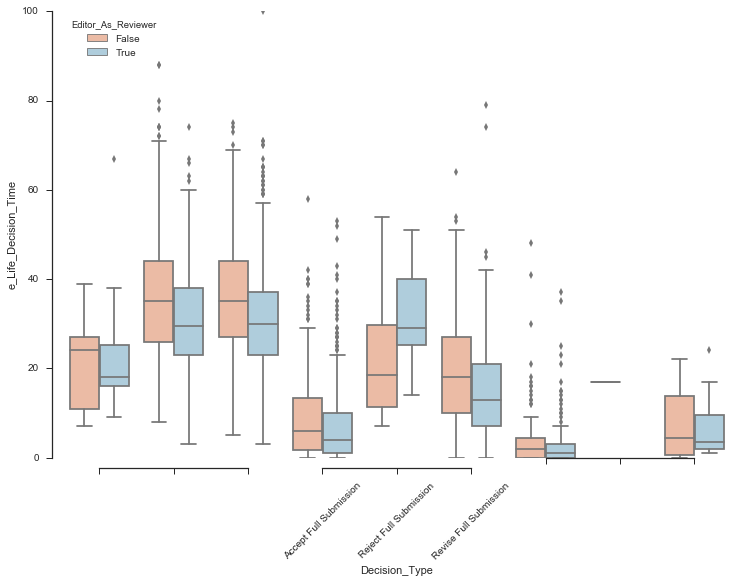

In [4]:
fig = plt.figure(figsize=(12, 8), dpi=250)
sns.set(style="ticks")

for n_revision in range(3):
    ax = fig.add_subplot(1, 3, n_revision+1)
    subset = post_peer_review[post_peer_review['Revision Number'] == n_revision]
    

    sns.boxplot(x='Decision_Type', y="e_Life_Decision_Time", hue="Editor_As_Reviewer",
                data=subset, palette="RdBu", ax=ax)
    ax.set_ylim(0, 100)
    
    # Format the x and y axis across subplots to make the plot look pretty.
    if n_revision == 0:
        sns.despine(ax=ax, offset=10, trim=True)
        ax.set_xticklabels([])
        ax.set_xlabel('')
    

    if n_revision == 1:
        sns.despine(ax=ax, left=True, offset=10, trim=True)
        ax.yaxis.set_visible(False)
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)       
        ax.legend_.remove()
        
            # keep y-axis
    if n_revision == 2:
        sns.despine(ax=ax, left=True, trim=True)
        ax.set_xlabel('')
        ax.set_xticklabels([])
        ax.yaxis.set_visible(False)
        ax.legend_.remove()

fig.subplots_adjust(wspace=0)

Reproduce Table 1 from the main paper.

We look at how the mean e_Life_Decision_Time / Author_Time varies across different rounds of revision as well as in function of having an editor as a reviewer.

We then do a Mann-Whitney test to check if having an editor as a reviewer influences the length of the duration process.  Since we do multiple comparisons, we correct the p-values using [Benjamini-Hochberg](https://en.wikipedia.org/wiki/False_discovery_rate#Benjamini.E2.80.93Hochberg_procedure)

In [5]:
means_elife_time = post_peer_review.pivot_table('e_Life_Decision_Time', index=['Decision_Type', 'Revision Number'],
                             columns='Editor_As_Reviewer')
means_author_time = post_peer_review.pivot_table('Author_Time', index=['Decision_Type', 'Revision Number'],
                             columns='Editor_As_Reviewer')

counts = post_peer_review.pivot_table('e_Life_Decision_Time', index=['Decision_Type', 'Revision Number'],
                             columns='Editor_As_Reviewer', aggfunc='count')
counts.fillna(0, inplace=True)

# Group papers across decision (accept/reject/revise) and revision number (0, 1, 2)
gb = post_peer_review.groupby(['Decision_Type', 'Revision Number'])

# We have to write our own function to apply a statistical test
# between the two subgroups
def apply_mw(x, col_name='e_Life_Decision_Time'):
    # 
    re_time = x[x['Editor_As_Reviewer']][col_name].values
    se_time = x[x['Editor_As_Reviewer'] == 0][col_name].values
    
    return mannwhitneyu(re_time, se_time)[1]



# Calculate Mann-Whitney between Reviewing Editor vs Non Reviewing Editor
mw_elife_time = gb.apply(apply_mw)
_, p_vals, _, _ = multipletests(mw_elife_time, method='fdr_bh')
mw_elife_time.values[:] = p_vals
mw_elife_time.name = 'M-W'


mw_author_time = gb.apply(apply_mw, 'Author_Time')
_, p_vals, _, _ = multipletests(mw_author_time, method='fdr_bh')
mw_author_time.values[:] = p_vals
mw_author_time.name = 'M-W'

pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.expand_frame_repr = True
pd.options.display.width = 20

bre_reviewer_effect = pd.concat([counts,
                                 means_elife_time.join(mw_elife_time),
                                 means_author_time.join(mw_author_time)],
                                 axis=1, keys=['counts', 'eLife Time', 'Author Time'])


#bre_reviewer_effect.index.rename(['Revision', 'Decision'], inplace=True)
display(bre_reviewer_effect.fillna('N/A'))

counts  \
Editor_As_Reviewer                       False   
Decision_Type          Revision Number           
Accept Full Submission 0                 5.000   
                       1               440.000   
                       2               115.000   
                       3                 6.000   
Reject Full Submission 0               461.000   
                       1                10.000   
                       2                 1.000   
                       3                 0.000   
Revise Full Submission 0               705.000   
                       1               129.000   
                       2                 6.000   
                       3                 0.000   

                                                \
Editor_As_Reviewer                        True   
Decision_Type          Revision Number           
Accept Full Submission 0                12.000   
                       1               650.000   
                       2               164.000   
                       3                11.000   
Reject Full Submission 0               616.000   
                       1                10.000   
                       2                 0.000   
                       3                 0.000   
Revise Full Submission 0               946.000   
                       1               182.000   
                       2                12.000   
                       3                 0.000   

                                       eLife Time  \
Editor_As_Reviewer                          False   
Decision_Type          Revision Number              
Accept Full Submission 0                   21.600   
                       1                    8.802   
                       2                    4.339   
                       3                    3.667   
Reject Full Submission 0                   36.104   
                       1                   22.200   
                       2                   17.000   
                       3                      N/A   
Revise Full Submission 0                   36.018   
                       1                   19.651   
                       2                    7.833   
                       3                      N/A   

                                               \
Editor_As_Reviewer                       True   
Decision_Type          Revision Number          
Accept Full Submission 0               23.333   
                       1                6.949   
                       2                3.238   
                       3                2.455   
Reject Full Submission 0               30.981   
                       1               31.600   
                       2                  N/A   
                       3                  N/A   
Revise Full Submission 0               31.053   
                       1               15.747   
                       2                7.167   
                       3                  N/A   

                                              \
Editor_As_Reviewer                       M-W   
Decision_Type          Revision Number         
Accept Full Submission 0               1.000   
                       1               0.006   
                       2               0.175   
                       3               0.747   
Reject Full Submission 0               0.000   
                       1               0.148   
                       2               0.000   
                       3                 N/A   
Revise Full Submission 0               0.000   
                       1               0.006   
                       2               0.747   
                       3                 N/A   

                                       Author Time  \
Editor_As_Reviewer                           False   
Decision_Type          Revision Number               
Accept Full Submission 0                     4.000   
                       1                    52.209   
               

Box Plots for Total Time

In [6]:
reviewer_decision_counts = post_peer_review.pivot_table('Manuscript_Number',
                index='Decision_Type', columns='Editor_As_Reviewer', aggfunc='count')
chi2_contingency(reviewer_decision_counts)

(2.1550936592668228,
 0.34042963401173282,
 2L,
 array([[  588.00133899,   814.99866101],
        [  460.17496095,   637.82503905],
        [  829.82370007,  1150.17629993]]))

In [7]:
reviewer_decision_counts.index=reviewer_decision_counts.index.tolist()  # Get rid of categorical
reviewer_decision_counts.ix['Totals'] = reviewer_decision_counts.sum(axis=0)
reviewer_decision_counts['Totals'] = reviewer_decision_counts.sum(axis=1)

reviewer_decision_counts

Editor_As_Reviewer,False,True,Totals
Accept Full Submission,566,837,1403
Reject Full Submission,472,626,1098
Revise Full Submission,840,1140,1980
Totals,1878,2603,4481


## Some statistical analysis

In [8]:
first_date = post_peer_review.groupby(level=0).first()[['Received Date', 'Editor_As_Reviewer']]
last_date = post_peer_review.groupby(level=0).last()[['Decision Date', 'Decision_Type']]

plot_df = pd.concat([first_date, last_date], axis=1)


plot_df['MS_NO'] = plot_df.index.get_level_values(0)

# Find first date:
first_pub = plot_df['Received Date'].copy()
first_pub.sort_values(inplace=True)
first_pub = first_pub.head(1).values

plot_df.columns = ['Received_Date', 'Editor_As_Reviewer', 'Decision_Date',
                   'Decision_Type', 'MS_NO']


plot_df['Total_Decision_Time'] = (last_date['Decision Date'] - first_date['Received Date']).dt.days
plot_df['Received_Since_Start'] =  (first_date['Received Date'] - first_pub).dt.days
plot_df['Publication_Since_Start'] =  (last_date['Decision Date'] - first_pub).dt.days
plot_df['Received_Date_Str'] = plot_df['Received_Date'].apply(lambda x: x.strftime('%d-%m-%Y'))
plot_df['Decision_Date_Str'] = plot_df['Decision_Date'].apply(lambda x: x.strftime('%d-%m-%Y'))

unique_reviewers = pd.read_csv(os.path.join(data_dir, 'Unique_Reviewers.csv'), index_col=0)
plot_df['Unique_Reviewers'] = unique_reviewers

for idx in plot_df.index:
    plot_df.loc[idx, 'Total_Revisions'] = len(post_peer_review.ix[idx])

In [9]:
decisions_df = plot_df[plot_df['Decision_Type'] != 'Revise Full Submission'].copy()  # drop papers that are in revision
decisions_df['accept'] = decisions_df['Decision_Type'] == 'Accept Full Submission'

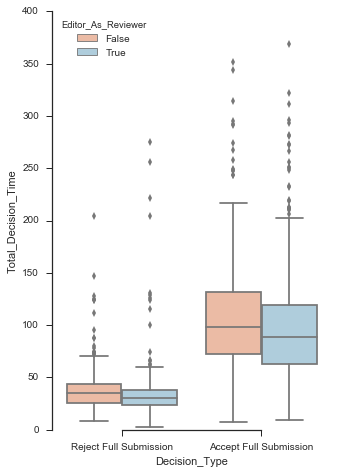

In [10]:
fig = plt.figure(figsize=(5, 7.5), dpi=250)
ax = fig.add_subplot(111)


sns.set(style="ticks")
sns.boxplot(x='Decision_Type', y="Total_Decision_Time", hue="Editor_As_Reviewer",
            data=decisions_df, palette="RdBu", ax=ax)
ax.set_ylim((0, 400), emit=True)
sns.despine(trim=True)


### Linear model to see if the BRE_Reviewer still has an effect on the total decision time after taking into account the number of unique reviewers (Table S1)

In [11]:
decisions_df['accept'] = decisions_df['accept'].astype('int')
formula = 'Total_Decision_Time ~ C(Editor_As_Reviewer) + Unique_Reviewers + C(Decision_Type)'
model = smf.glm(formula=formula, data=decisions_df).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     Total_Decision_Time   No. Observations:                 2500
Model:                             GLM   Df Residuals:                     2496
Model Family:                 Gaussian   Df Model:                            3
Link Function:                identity   Scale:                   1618.65575024
Method:                           IRLS   Log-Likelihood:                -12782.
Date:                 Mon, 28 Mar 2016   Deviance:                   4.0402e+06
Time:                         16:50:08   Pearson chi2:                 4.04e+06
No. Iterations:                      4                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------
Intercept                                     85.7868      4.462     19.225      0.000        77.041    94.533
C(Editor_As_Reviewer)[T.True]                 -9.2265      1.701     -5.425      0.000       -12.560    -5.893
C(Decision_Type)[T.Reject Full Submission]   -65.3500      1.622    -40.285      0.000       -68.529   -62.171
Unique_Reviewers                               7.1892      1.620      4.438      0.000         4.014    10.364
==============================================================================================================
"""

### Logit model to test whether the odds of a paper being accepted are affected by the kind of editor (reviewing versus supervising) and how many days since eLife started accepting papers.  Table S2.

In [12]:
decisions_df['accept'] = decisions_df['accept'].astype('int')
formula = 'accept ~ C(Editor_As_Reviewer) + Publication_Since_Start + Unique_Reviewers'
model = smf.logit(formula=formula, data=decisions_df).fit()
display(model.summary())

Optimization terminated successfully.
         Current function value: 0.684062
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 accept   No. Observations:                 2500
Model:                          Logit   Df Residuals:                     2496
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Mar 2016   Pseudo R-squ.:                0.002298
Time:                        16:50:08   Log-Likelihood:                -1710.2
converged:                       True   LL-Null:                       -1714.1
                                        LLR p-value:                   0.04858
=================================================================================================
                                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept                         0.6080      0.257      2.368      0.018         0.105     1.111
C(Editor_As_Reviewer)[T.True]     0.0822      0.087      0.946      0.344        -0.088     0.252
Publication_Since_Start          -0.0003      0.000     -2.393      0.017        -0.001 -6.08e-05
Unique_Reviewers                 -0.0380      0.081     -0.468      0.640        -0.197     0.121
=================================================================================================
"""

Logit model to test whether the number of revisions a paper goes through before it is accepted are influenced by the number of days since eLife started accepting papers plus the type of reviewer.

In [13]:
formula = 'Total_Revisions ~ Publication_Since_Start + Editor_As_Reviewer + C(Decision_Type) + Unique_Reviewers'
model = smf.glm(formula=formula, data=decisions_df, family=sm.families.Poisson()).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Total_Revisions   No. Observations:                 2500
Model:                            GLM   Df Residuals:                     2495
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -3060.5
Date:                Mon, 28 Mar 2016   Deviance:                       141.82
Time:                        16:50:08   Pearson chi2:                     156.
No. Iterations:                     7                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------
Intercept                                      0.6856      0.099      6.951      0.000         0.492     0.879
Editor_As_Reviewer[T.True]                    -0.0134      0.033     -0.403      0.687        -0.078     0.052
C(Decision_Type)[T.Reject Full Submission]    -0.7762      0.035    -22.216      0.000        -0.845    -0.708
Publication_Since_Start                     1.058e-05   5.33e-05      0.198      0.843      -9.4e-05     0.000
Unique_Reviewers                               0.0382      0.031      1.230      0.219        -0.023     0.099
==============================================================================================================
"""

## Analyze Citation Data

In [14]:

citations = pd.read_csv(os.path.join(data_dir, 'Citations_for_papers.csv'), index_col=0, header=0)
citations.index = citations.index.values.astype('int')

In [15]:
plot_df = pd.concat([plot_df, citations], axis=1)
plot_df.dropna(subset=['Received_Date'], inplace=True)
plot_df = plot_df.rename(columns = {'www.ncbi.nlm.nih.gov': 'Pubmed_Citations',
                                    'www.scopus.com': 'Scopus'})
plot_df['Pubmed_Citations'].fillna(0, inplace=True)
plot_df['Scopus'].fillna(0, inplace=True)

We look whether the number of citations in SCOPUS is influenced by the kind of reviewer, the days since eLife started publishing papers, and the decision time.  Table S4.

In [16]:
accepted_papers = plot_df[plot_df['Decision_Type'] == 'Accept Full Submission'].copy()
accepted_papers['log1p_Scopus'] = np.log1p(accepted_papers['Scopus'])

formula = 'log1p_Scopus ~ Total_Decision_Time + Editor_As_Reviewer + Publication_Since_Start + Unique_Reviewers'
model = smf.glm(formula=formula, data=accepted_papers).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           log1p_Scopus   No. Observations:                 1403
Model:                            GLM   Df Residuals:                     1398
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                  0.548529446386
Method:                          IRLS   Log-Likelihood:                -1567.0
Date:                Mon, 28 Mar 2016   Deviance:                       766.84
Time:                        16:50:08   Pearson chi2:                     767.
No. Iterations:                     4                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                      2.7590      0.128     21.637      0.000         2.509     3.009
Editor_As_Reviewer[T.True]     0.0947      0.043      2.203      0.028         0.010     0.179
Total_Decision_Time           -0.0004      0.000     -1.124      0.261        -0.001     0.000
Publication_Since_Start       -0.0025   6.97e-05    -35.472      0.000        -0.003    -0.002
Unique_Reviewers               0.0609      0.040      1.520      0.129        -0.018     0.139
==============================================================================================
"""

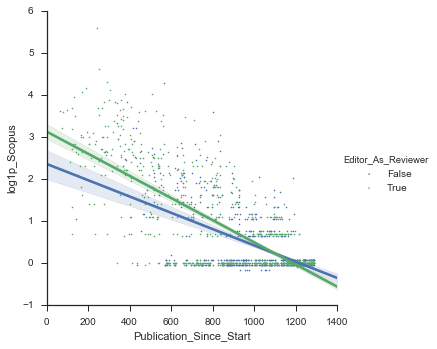

In [17]:
sns.lmplot('Publication_Since_Start', 'log1p_Scopus', data=accepted_papers, hue='Editor_As_Reviewer',
           y_partial='Unique_Reviewers', 
           scatter_kws={'alpha':1, 'marker': '.', 's': 2.5})

Let's try some nice data-visualizations now:

In [18]:
plot_df['Color'] = 'red'
plot_df.loc[plot_df['Editor_As_Reviewer'] == 1, 'Color'] = 'blue'

for idx in plot_df.index:
    plot_df.loc[idx, 'Total_Revisions'] = len(post_peer_review.ix[idx])

accepted = plot_df[plot_df['Decision_Type'] == 'Accept Full Submission'].copy()
rejected = plot_df[plot_df['Decision_Type'] == 'Reject Full Submission'].copy()
revised = plot_df[plot_df['Decision_Type'] == 'Revise Full Submission'].copy()


In [19]:
output_notebook()
all_figs = []
for title, df in zip(['Accepted', 'Revised', 'Rejected'],
                     [accepted, revised, rejected]):

    hover = HoverTool(
        tooltips=[
            ("Manuscript Number", "@MS_NO"),
            ("Received Date", "@Received_Date_Str"),
            ("Final Decision Date", "@Decision_Date_Str"),
            ("Total Revisions:", "@Total_Revisions")
        ]
    )
    
    
    data = ColumnDataSource(df)
    p = figure(width=800, height=800, x_axis_type="datetime",
              tools=[hover], title=title)
    p.circle('Received_Date', 'Total_Decision_Time', color='Color', alpha=0.5, 
              source=data)
    
    p.xaxis.axis_label = 'Date Received'
    p.yaxis.axis_label = 'Days Till Decision'
    
    tab = Panel(child=p, title=title)
    all_figs.append(tab)


tabs = Tabs(tabs=all_figs)
show(tabs)

BokehJS successfully loaded.